In [24]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [26]:
import numpy as np
import scipy as sp
import random
import string
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
from sklearn.cluster import KMeans
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
sns.set(style='white', color_codes=True, font_scale=1.3)

### Dataset Generation: 

To ensure that unsupervised learning methods can work on data of this shape, a syntethic dataset was created which follows the form of available ESG data on Yahoo Finance. A score for Environment, Social and Governance factors are provided, along with a randomly generated 4-character ticker. 

By generating the data in this format, the same code can be used and run once the real data is pulled from Yahoo finance. 

In [27]:
# Generate Random Data: 
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, 
                  centers=[(10, 10, 10), (50, 50, 50), (90, 90, 90)], 
                  cluster_std=10, 
                  n_features=3)

df = pd.DataFrame(X, columns=['Environment', 'Social', 'Governance'])
df['Ticker'] = [''.join(random.choices(string.ascii_uppercase, k=4)) for i in range(len(df))]
df.head()

,Environment,Social,Governance,Ticker
0,7.228978,29.688266,3.176949,VYMW
1,93.789676,104.533665,97.881878,CUMT
2,89.953251,82.885263,92.800362,LITS
3,18.346130,21.677894,0.230856,TGOY
4,54.017185,69.291043,63.070163,BQVJ


In [28]:
def elbow(df, pair): 
    # Elbow method to Determine K 
    X = df 
    K = range(1,11)  # Apply kmeans 1 to 10
    kmeans_models = [KMeans(k).fit(X) for k in K]
    centroids = [m.cluster_centers_ for m in kmeans_models]
    D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    # plot elbow curve
    plt.figure(figsize = (7,7))
    plt.plot(K, avgWithinSS, 'b*-')
    plt.xlabel('Number of clusters');
    plt.ylabel('Average within-cluster sum of squares');
    plt.title('Elbow for K-Means clustering');
    plt.suptitle('{}'.format(pair))
    plt.show()

# A helper function to run and plot K-means:     
def kmeans(df, pair, k):
    # Fitting the K-Means model: 
    k_means_model = KMeans(n_clusters=k)
    k_means_model.fit(df)
    centroids = k_means_model.cluster_centers_
    centroids

    # Plot the clusters with their centroids.
    df['cluster_labels_kmeans'] = k_means_model.labels_
    f = sns.lmplot(x=pair[0], y=pair[1], data=df, hue = 'cluster_labels_kmeans', 
                   fit_reg=False, size=5, aspect=1.3)
    f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
                 linewidths=2, color='k');
    plt.title('{}'.format(pair), fontsize=15)

### Cluster Identification: 

The following plot identifies the optimal number of groups to detect in the dataset. Typically, the optimal number of groups is shown by the "elbow" in the plot. At this point, finding additional groups beyond the elbow yield no more information. These groups would associate to ESG rankings - "Underperformers", "Average Performers" and "Overperformers". 

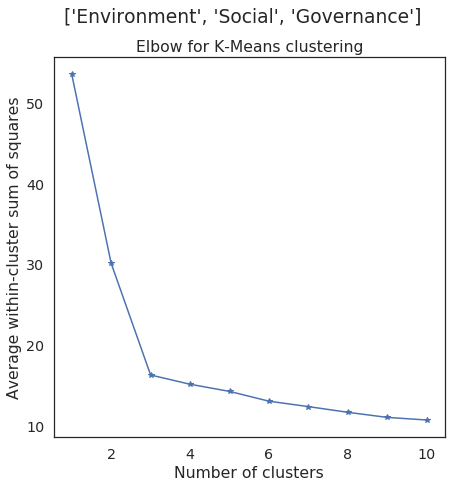

In [29]:
elbow(df[['Environment', 'Social', 'Governance']], ['Environment', 'Social', 'Governance'])

### K-Means Clustering with Interactive Visualization: 

Here - we demonstrate the findings of the K-means unsupervised learning method. The algorithm successfully identified 3 groups, which represent the ESG "Underperformers", "Average Performars" and "Over Performers". The findings of this algorithm are data dependent, so it has yet to be determined if the same results will arise on the real data set. 

The insights of unsupervised learning allow users to find mathematical structure in the data. By looking at this, a company would be able to see a more robust representation of their ESG performance against their peers. While the visualization is simple, it demonstrates that there is a _material_ effect on sustainalytics rankings on a given company's perception in the public. 

In [33]:
features = ['Environment', 'Social', 'Governance']

k_means_model = skc.KMeans(n_clusters=3)
k_means_model.fit(df[features])
centroids = k_means_model.cluster_centers_

# Create traces

trace0 = go.Scatter(
    x = df['Environment'],
    y = df['Social'],
    text = df['Ticker'],
    mode = 'markers',
    name = 'markers', 
    marker = dict(
        color = k_means_model.labels_,
        colorscale='Portland',
    )
)

layout = go.Layout( 
    title = 'Environment vs. Social Score',
    hovermode = 'closest',
    xaxis= dict(
        title= 'Environment',
        ticklen= 5,
        zeroline=True,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Social',
        ticklen= 5,
        gridwidth= 2,
    ),

    
)

data = [trace0]

fig= go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0, 100])
fig.update_yaxes(range=[0, 100])

fig.show()